# Bayesian Analysis of Linear Regression
Use this for Bayesian analysis of linear models with and without measurement error.

In [28]:
# Load Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import corner
import pymc as pm
import arviz as az
from scipy.stats import invgamma, norm, gamma, multivariate_normal, linregress
from statsmodels.graphics.tsaplots import plot_acf
from numpy.lib.histograms import histogram
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

print('pymc version', pm.__version__)
print('arviz version', az.__version__)
print('numpy version', np.__version__)
print('pandas version', pd.__version__)
print('seaborn version', sns.__version__)
print('Pyplot (Matplotlib) version:', plt.matplotlib.__version__)

pymc version 5.16.1
arviz version 0.17.1
numpy version 1.26.4
pandas version 2.2.2
seaborn version 0.13.2
Pyplot (Matplotlib) version: 3.8.4


## Load the Data

In [29]:
# Load and view file.

data = pd.read_csv("data/zaw_table_4_for_model_test.csv")

data

,MassBH,e_MassBH,sigma,e_sigma
0,6.041393,0.079850,-0.403403,0.016500
1,6.863323,0.011901,-0.305395,0.044018
2,6.447158,0.031074,-0.259637,0.051567
3,6.397940,0.048846,-0.139662,0.020982
4,6.204120,0.110924,-0.283997,0.012531
...,...,...,...,...
131,9.568202,0.230805,0.201397,0.002731
132,9.959041,0.138103,0.130334,0.043575
133,9.857332,0.150515,0.263636,0.010652
134,10.230449,0.077451,0.221414,0.022190


## Examine the entire data set

In [30]:
# Examine data.

data_stats = data.describe()
data_stats

,MassBH,e_MassBH,sigma,e_sigma
count,136.000000,136.000000,136.000000,136.000000
mean,8.055610,0.168094,-0.050123,0.024548
std,1.033879,0.162074,0.178805,0.017704
min,6.041393,0.011901,-0.474955,0.002608
25%,7.295461,0.074947,-0.171503,0.016563
50%,7.977121,0.132896,-0.042155,0.020829
75%,8.788499,0.207894,0.077821,0.026033
max,10.322219,1.265100,0.288920,0.155790


In [31]:
# Convert coluum headers to generic X and Y. This code will work for any linear analysis.

data = data.rename(columns={"MassBH": "Y", "e_MassBH": "Y_err", "sigma": "X", "e_sigma": "X_err"})
data

,Y,Y_err,X,X_err
0,6.041393,0.079850,-0.403403,0.016500
1,6.863323,0.011901,-0.305395,0.044018
2,6.447158,0.031074,-0.259637,0.051567
3,6.397940,0.048846,-0.139662,0.020982
4,6.204120,0.110924,-0.283997,0.012531
...,...,...,...,...
131,9.568202,0.230805,0.201397,0.002731
132,9.959041,0.138103,0.130334,0.043575
133,9.857332,0.150515,0.263636,0.010652
134,10.230449,0.077451,0.221414,0.022190


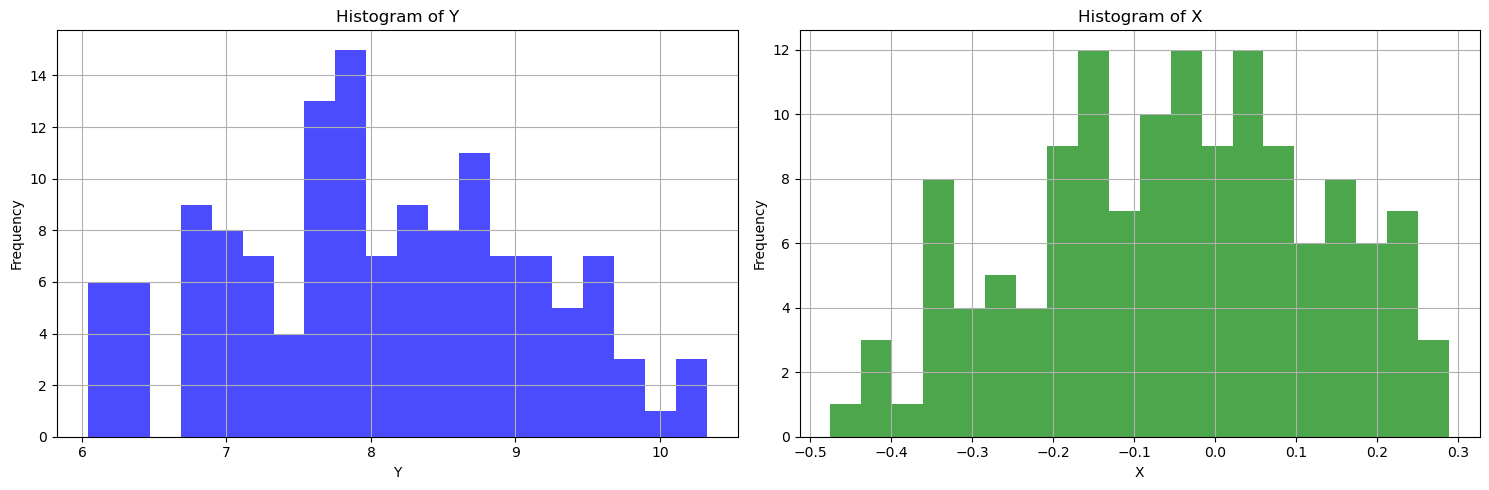

In [32]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size as needed

# Histogram for Y
axs[0].hist(data['Y'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Y')
axs[0].set_xlabel('Y')
axs[0].set_ylabel('Frequency')
axs[0].grid()

# Histogram for Density
axs[1].hist(data['X'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Histogram of X')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Frequency')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

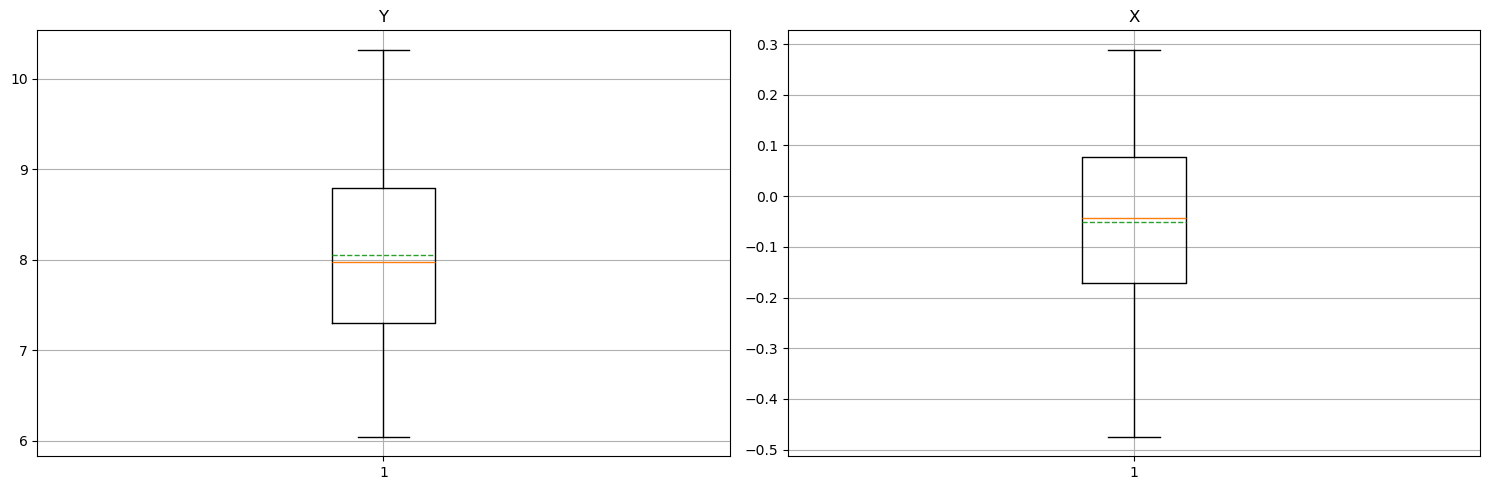

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size as needed

# Box plot for Y
axs[0].boxplot(data['Y'], showmeans=True, meanline=True)
axs[0].set_title('Y')
axs[0].grid()

# Box plot for X
axs[1].boxplot(data['X'], showmeans=True, meanline=True)
axs[1].set_title('X')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

### Corner Plot

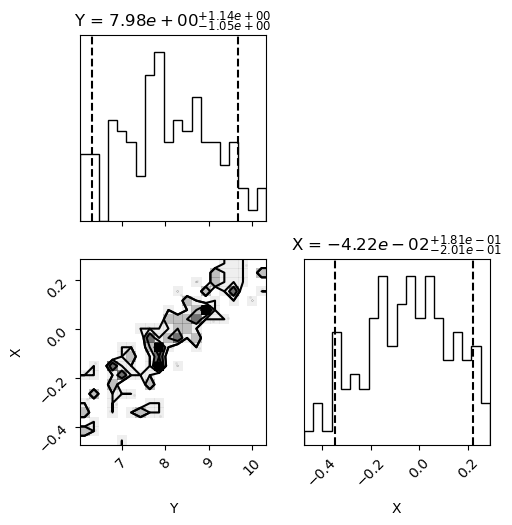

In [34]:
# Change to mumpy array for corner plot.
data_array = data.to_numpy()

# Generate the corner plot
figure = corner.corner(data_array[:, [0, 2]], labels=["Y", "X"], quantiles=(0.05, 0.95), show_titles=True, title_fmt=".2e")
figure.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

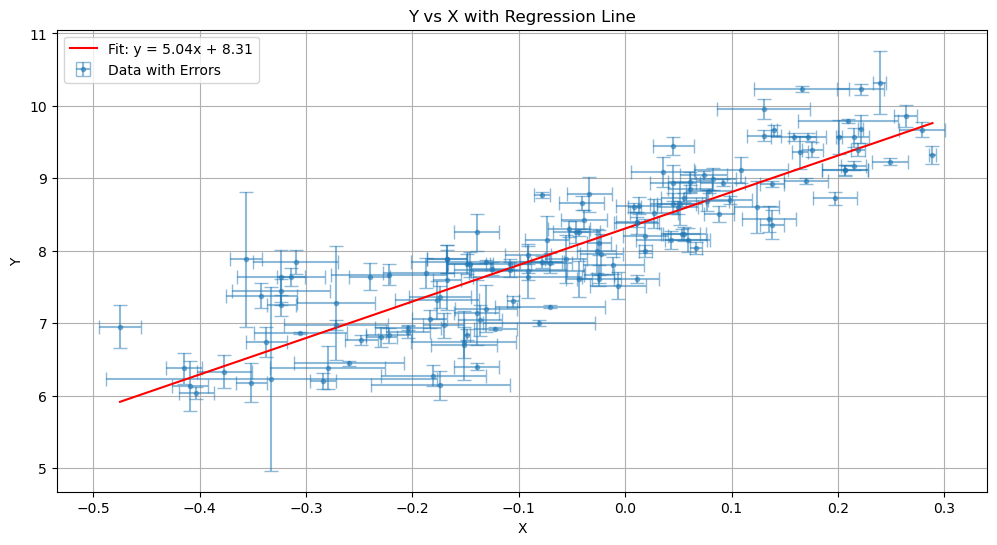

In [35]:
# Fit a linear regression line to reverse the roles of Y and X
slope, intercept = np.polyfit(data['X'], data['Y'], 1)  # Reverse x and y for linear fit

# Create the scatter plot with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(
    data['X'], 
    data['Y'], 
    xerr=data['X_err'], 
    yerr=data['Y_err'], 
    fmt='o', 
    capsize=5, 
    markersize=3, 
    alpha=0.5, 
    label="Data with Errors"
)

# Add the regression line
x_vals = np.linspace(min(data['X']), max(data['X']), 100)  # Generate x values for the line
y_vals = slope * x_vals + intercept  # Compute corresponding y values
plt.plot(x_vals, y_vals, color='red', label=f"Fit: y = {slope:.2f}x + {intercept:.2f}")

# Add labels, title, and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Y vs X with Regression Line')
plt.legend()
plt.grid()

# Show the plot
plt.show()


# Bayesian Linear Regression

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, sigma]
INFO:pymc.sampling.mcmc:NUTS: [b0, b1, sigma]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 27 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 27 seconds.


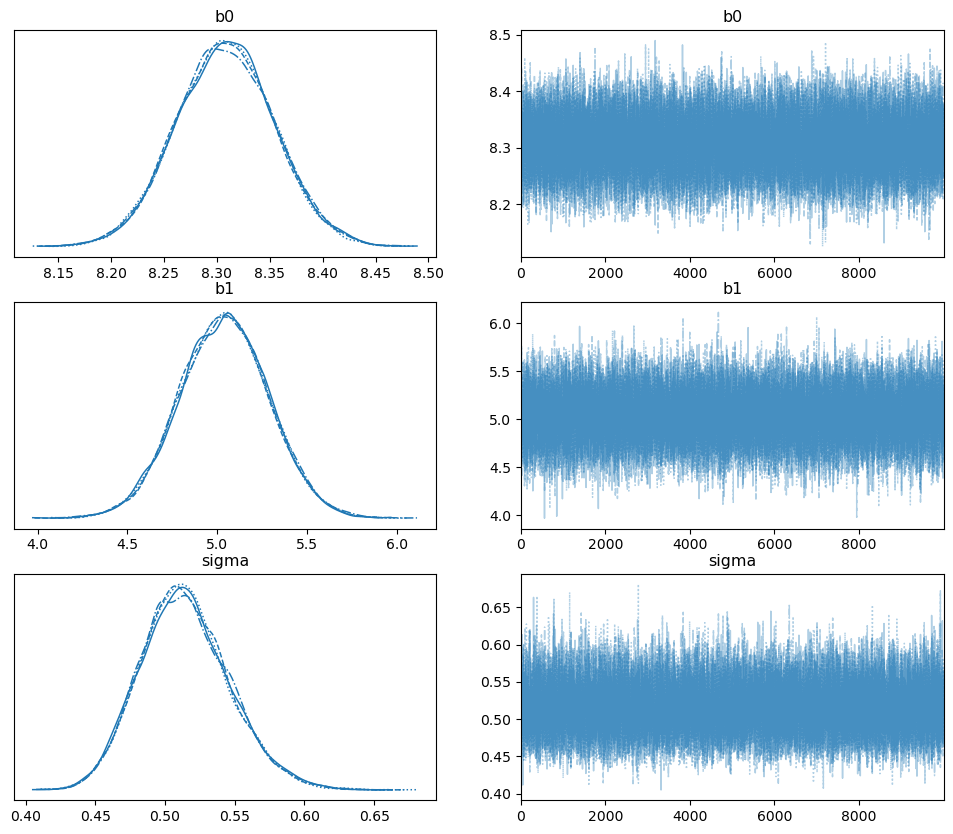

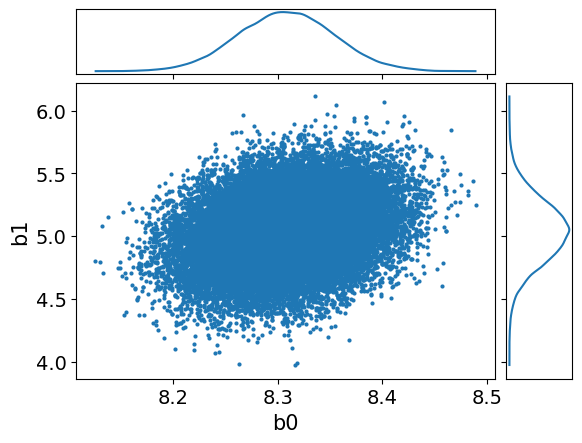

In [36]:
RANDOM_SEED = 5731

# Set mu and sigma for b0, b1 and sigma
mu_prior = 0
sigma_prior = 100
sigma1_prior = 1

with pm.Model() as model:
    # Define priors with tighter distributions
    b0 = pm.Normal("b0", mu=mu_prior, sigma=sigma_prior)
    b1 = pm.Normal("b1", mu=mu_prior, sigma=sigma_prior)
    sigma = pm.HalfNormal("sigma", sigma=sigma1_prior)  # Prior for residual standard deviation
    
    # Define linear model
    mu = b0 + b1 * data["X"]  # Linear predictor (removed the .values. I don't know if it is needed.)
    
    # Define likelihood with uncertainty
    #y = pm.StudentT("y", mu=mu, sigma=sigma, nu=4, observed=data["Y"]) # StudentT allow for wider distribution and outliers.
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data["Y"])
    
    # Sample the posterior
    trace = pm.sample(
        random_seed=RANDOM_SEED,
        draws=10000,
        chains=4,
        target_accept=0.75,
        tune=2000
    )

# Inspect diagnostics
az.plot_trace(trace, figsize=(12, 10));
az.plot_pair(trace, var_names=["b0", "b1"], divergences=True, marginals=True);


In [37]:
print(trace.posterior)

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 10000)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    b0       (chain, draw) float64 8.365 8.303 8.285 8.384 ... 8.298 8.298 8.298
    b1       (chain, draw) float64 5.239 5.104 5.713 5.205 ... 5.14 5.14 5.14
    sigma    (chain, draw) float64 0.4412 0.5612 0.5409 ... 0.4819 0.4819 0.4819
Attributes:
    created_at:                 2024-11-22T03:28:49.985363
    arviz_version:              0.17.1
    inference_library:          pymc
    inference_library_version:  5.16.1
    sampling_time:              26.509584188461304
    tuning_steps:               2000


RESULTS FOR LINEAR MODEL WITHOUT MEASUREMENT ERROR
Prior mu and sigma for normal distribution for b0 and b1: 0 , 100
Prior sigma for halfnormal for sigma: 1

        mean     sd  hdi_3%  hdi_97%
b0     8.308  0.046   8.222    8.394
b1     5.037  0.248   4.572    5.500
sigma  0.514  0.032   0.454    0.573


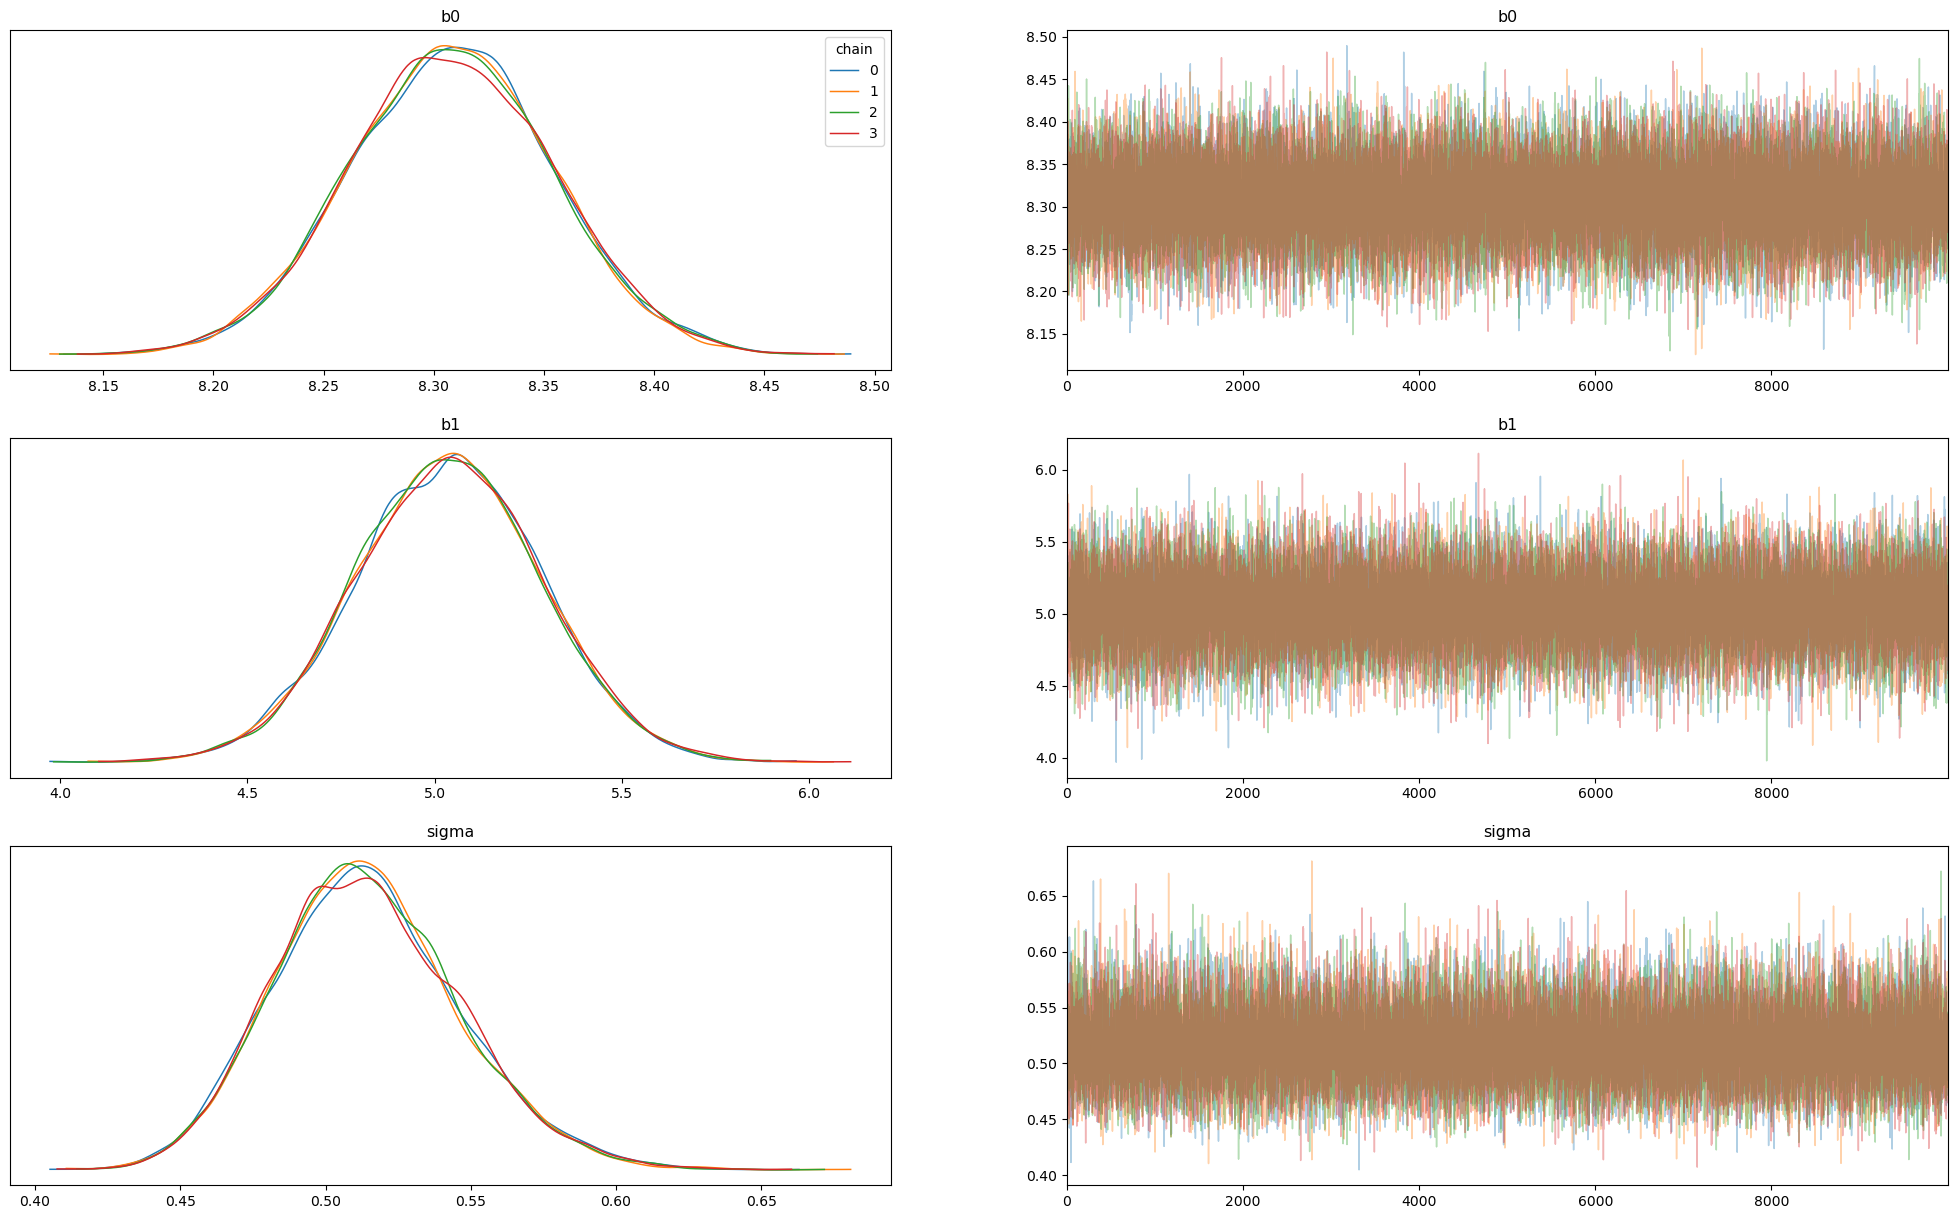

In [38]:
# Summary table of the trace
print('RESULTS FOR LINEAR MODEL WITHOUT MEASUREMENT ERROR')
print('Prior mu and sigma for normal distribution for b0 and b1:', mu_prior, ',', sigma_prior)
print('Prior sigma for halfnormal for sigma:', sigma1_prior)
print()
trace_summary = az.summary((trace.posterior), kind="stats", var_names=["b0", "b1", "sigma"])
print(trace_summary)

# Trace plots
subsampled_trace = trace.sel(draw=slice(0, None, 1))
az.plot_trace(subsampled_trace, var_names=["b0", "b1", "sigma"], figsize=(25,15), compact=False, legend=True);

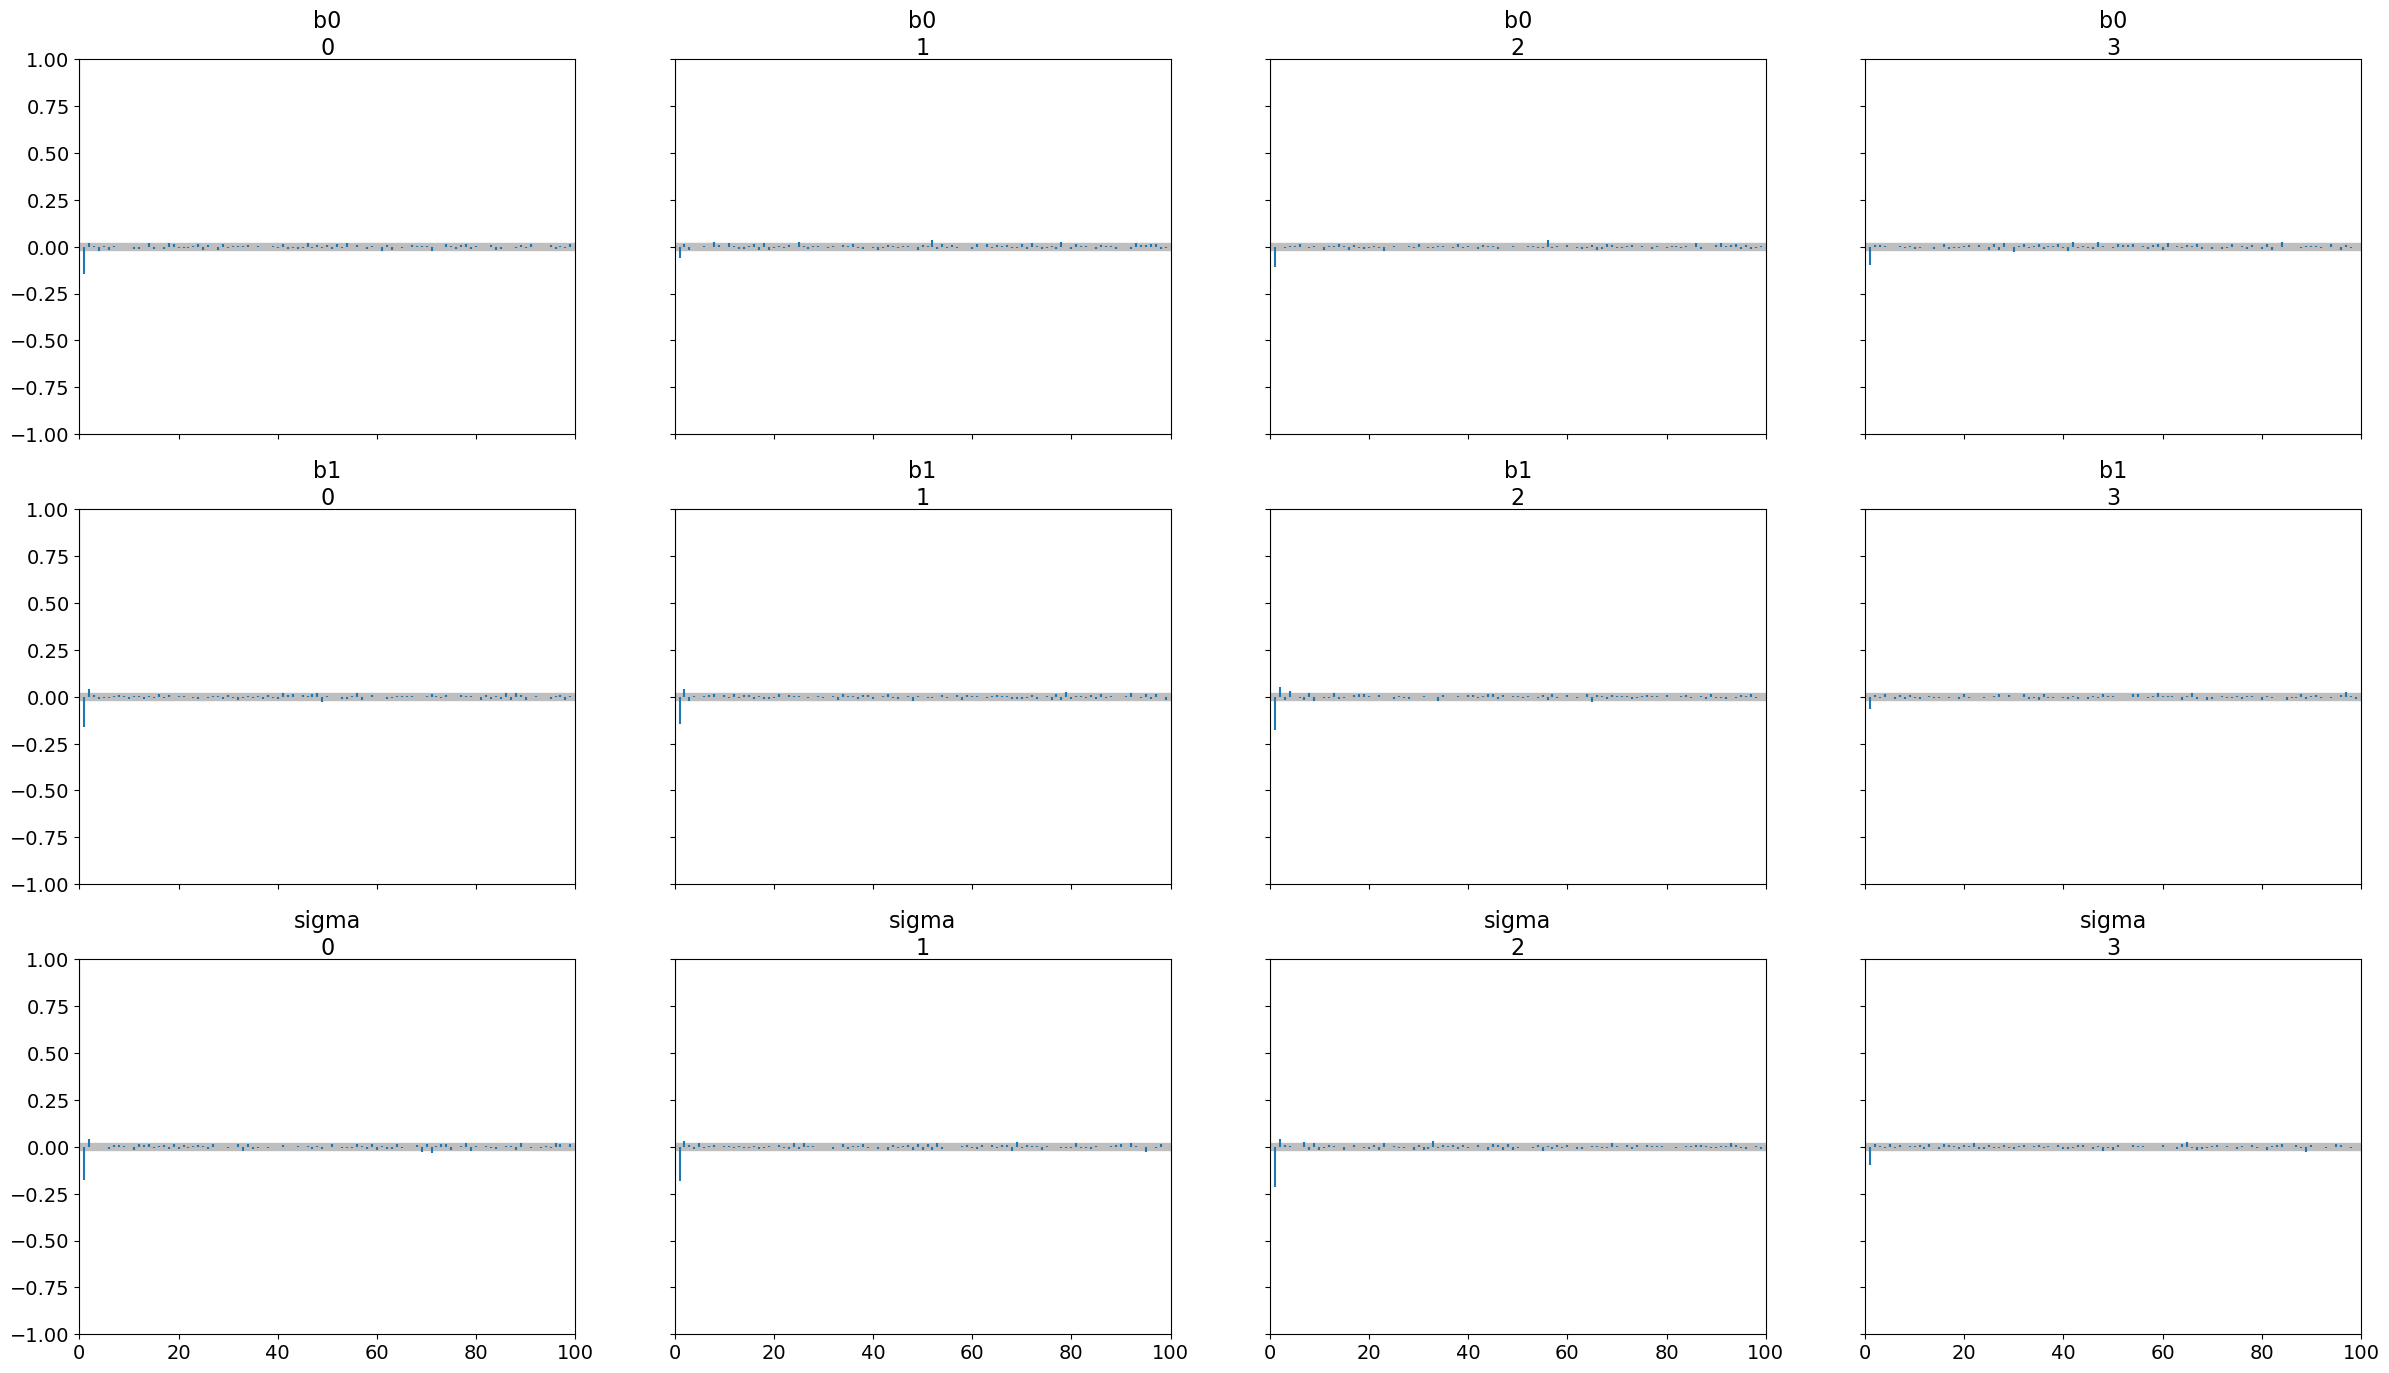

In [39]:
az.plot_autocorr(trace, var_names=['b0', 'b1', 'sigma'], figsize=None, grid=(3, 4) );

In [40]:
# Effective Sample Size
az.ess(trace, relative=False, var_names=["b0", "b1", "sigma"])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b0       float64 4.952e+04
    b1       float64 5.059e+04
    sigma    float64 5.325e+04

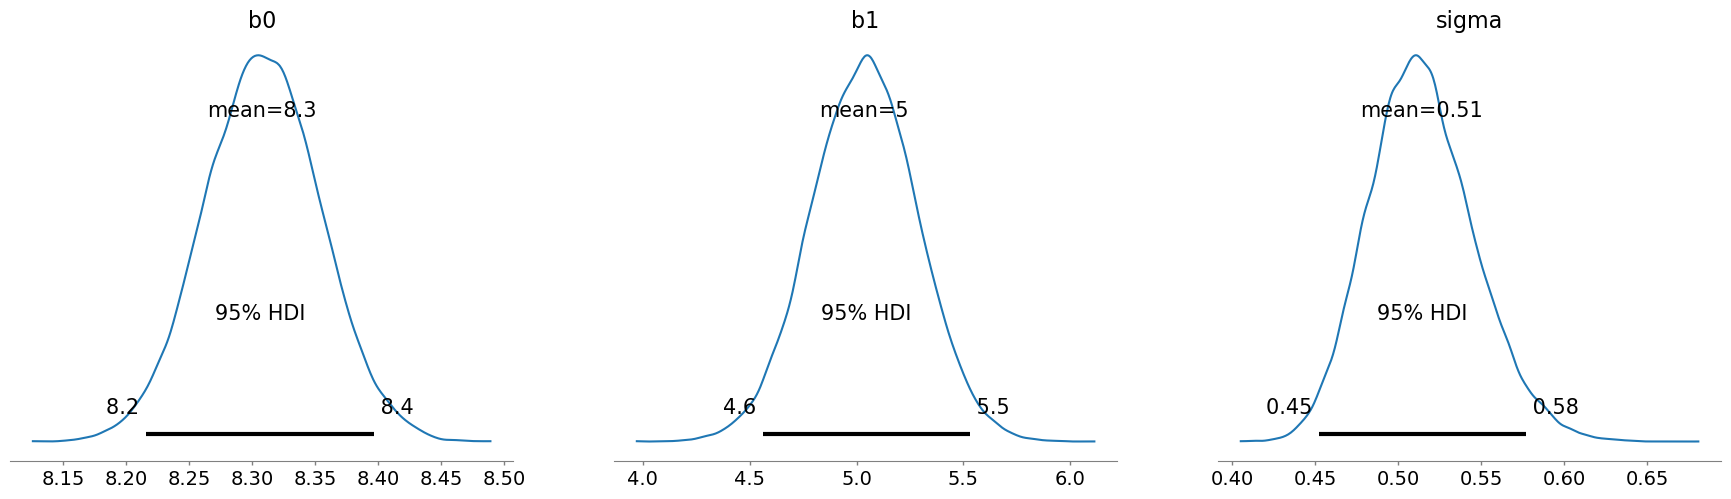

In [41]:
# Plot posterior histograms for beta0, beta1, and beta2
az.plot_posterior(trace, var_names=["b0", "b1", "sigma"],  hdi_prob=0.95);

## Posterior Predictive

Sampling: [y]
INFO:pymc.sampling.forward:Sampling: [y]


Output()

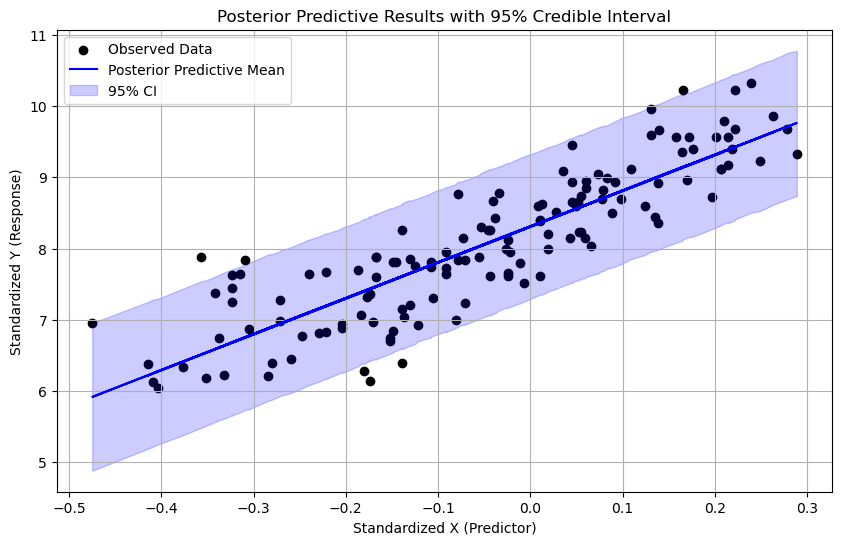

In [42]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

trace.extend(posterior_predictive) # Add poster_predictive to trace.

# Extract posterior predictive samples
y_pred = posterior_predictive.posterior_predictive["y"].values

# Flatten
y_pred = y_pred.reshape(-1, y_pred.shape[-1])  # Combine chains and draws

y_mean = np.mean(y_pred, axis=0)
y_lower = np.percentile(y_pred, 2.5, axis=0)
y_upper = np.percentile(y_pred, 97.5, axis=0)

array = np.array([data["X"], y_mean, y_lower, y_upper]).T 
plot_data = pd.DataFrame(data = array, columns = ['X', 'mean', 'lower', 'upper'])
plot_data = plot_data.sort_values(by='X')

plt.figure(figsize=(10, 6))
plt.scatter(data["X"], data["Y"], color="black", label="Observed Data")
plt.plot(data["X"], y_mean, color="blue", label="Posterior Predictive Mean")
plt.fill_between(plot_data["X"], plot_data['lower'], plot_data['upper'], color="blue", alpha=0.2, label="95% CI")
plt.xlabel("Standardized X (Predictor)")
plt.ylabel("Standardized Y (Response)")
plt.title("Posterior Predictive Results with 95% Credible Interval")
plt.legend()
plt.grid()
plt.show()


# Bayesian Quadratic Regression with Measurement Error

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, X_true, sigma, Y_true]
INFO:pymc.sampling.mcmc:NUTS: [b0, b1, X_true, sigma, Y_true]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 36 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 36 seconds.


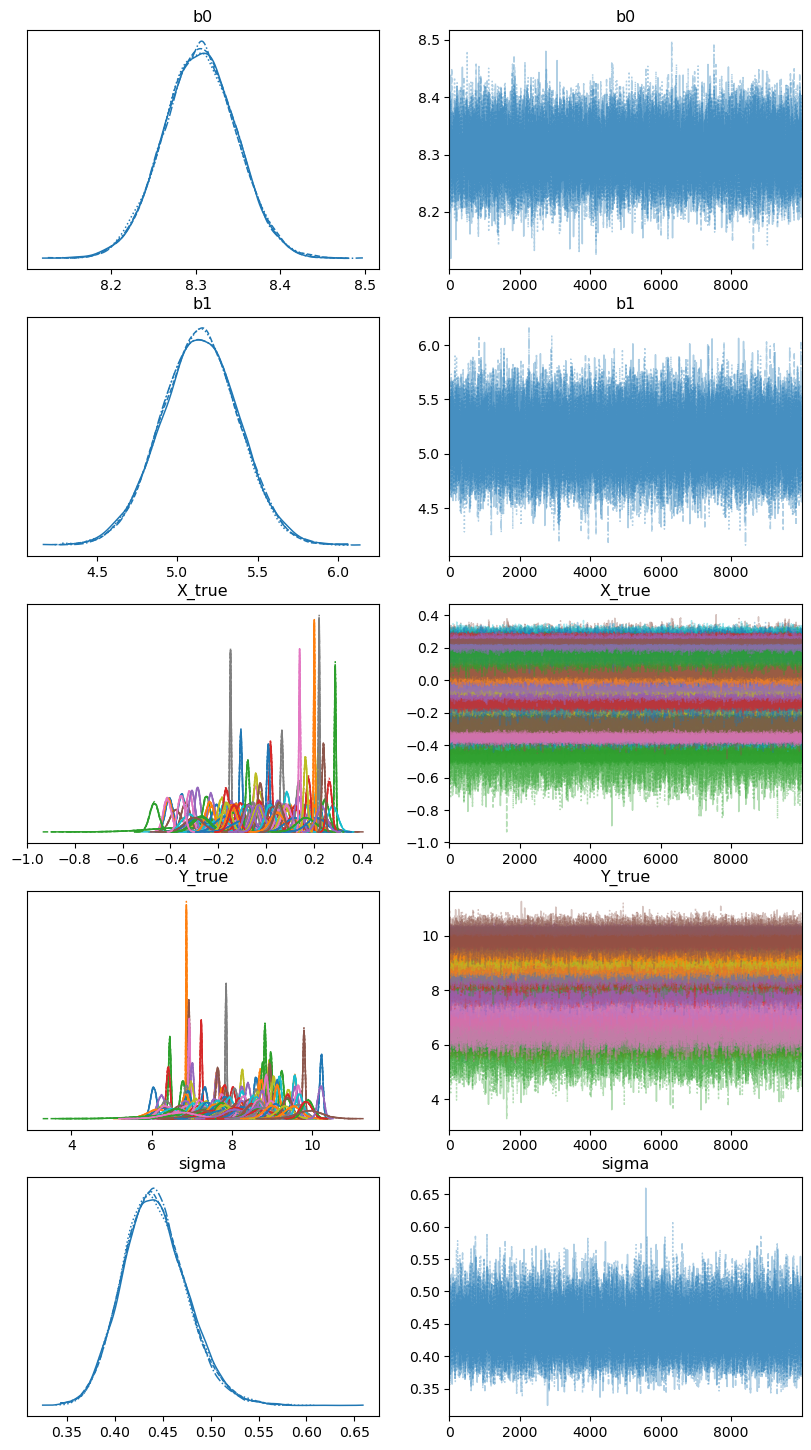

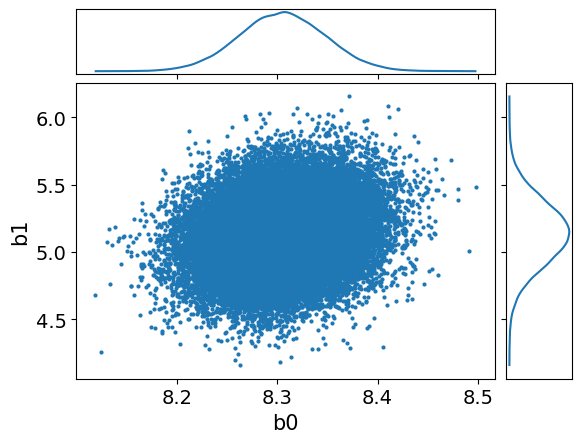

In [43]:
RANDOM_SEED = 5731

# Using the same values for prior mu and sigma as the errorless model above.

with pm.Model() as model_err:
    # Priors for regression coefficients
    b0 = pm.Normal("b0", mu=mu_prior, sigma=sigma_prior)
    b1 = pm.Normal("b1", mu=mu_prior, sigma=sigma_prior)

    # True latent predictor with measurement error
    X_true = pm.Normal("X_true", mu=data["X"], sigma=data["X_err"], shape=len(data["X"]))    

    # Residual variability for the response
    sigma = pm.HalfNormal("sigma", sigma=sigma1_prior)  # Residual standard deviation

    # Linear model
    mu = b0 + b1 * X_true

    # Likelihood for observed response (Y) with residual variability
    Y_true = pm.Normal("Y_true", mu=mu, sigma=sigma)
    Y_obs = pm.Normal('Y_obs', mu=Y_true, sigma=data['Y_err'], observed=data['Y'])
    
    # Sample posterior
    trace_err = pm.sample(
        draws=10000, 
        tune=2000, 
        random_seed=RANDOM_SEED, 
        target_accept=0.75
        )

# Inspect diagnostics
az.plot_trace(trace_err, figsize=(10, 18))
az.plot_pair(trace_err, var_names=["b0", "b1"], divergences=True, marginals=True);

In [44]:
print(trace_err.posterior)

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 10000, X_true_dim_0: 136, Y_true_dim_0: 136)
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * X_true_dim_0  (X_true_dim_0) int32 0 1 2 3 4 5 6 ... 130 131 132 133 134 135
  * Y_true_dim_0  (Y_true_dim_0) int32 0 1 2 3 4 5 6 ... 130 131 132 133 134 135
Data variables:
    b0            (chain, draw) float64 8.361 8.321 8.322 ... 8.264 8.306 8.323
    b1            (chain, draw) float64 4.956 5.177 5.081 ... 5.159 4.798 5.318
    X_true        (chain, draw, X_true_dim_0) float64 -0.4113 -0.2805 ... 0.2406
    Y_true        (chain, draw, Y_true_dim_0) float64 6.104 6.848 ... 10.3 9.784
    sigma         (chain, draw) float64 0.4249 0.4452 0.4238 ... 0.4975 0.4421
Attributes:
    created_at:                 2024-11-22T03:29:35.399731
    arviz_version:              0.17.1
    inference_library:          pymc
    inference_library_version:  5.16.1
    sa

RESULTS FOR LINEAR MODEL WITH MEASUREMENT ERROR
Prior mu and sigma for normal distribution for b0 and b1: 0 , 100
Prior sigma for halfnormal for sigma: 1

        mean     sd  hdi_3%  hdi_97%
b0     8.305  0.043   8.223    8.385
b1     5.138  0.241   4.695    5.598
sigma  0.442  0.033   0.382    0.507


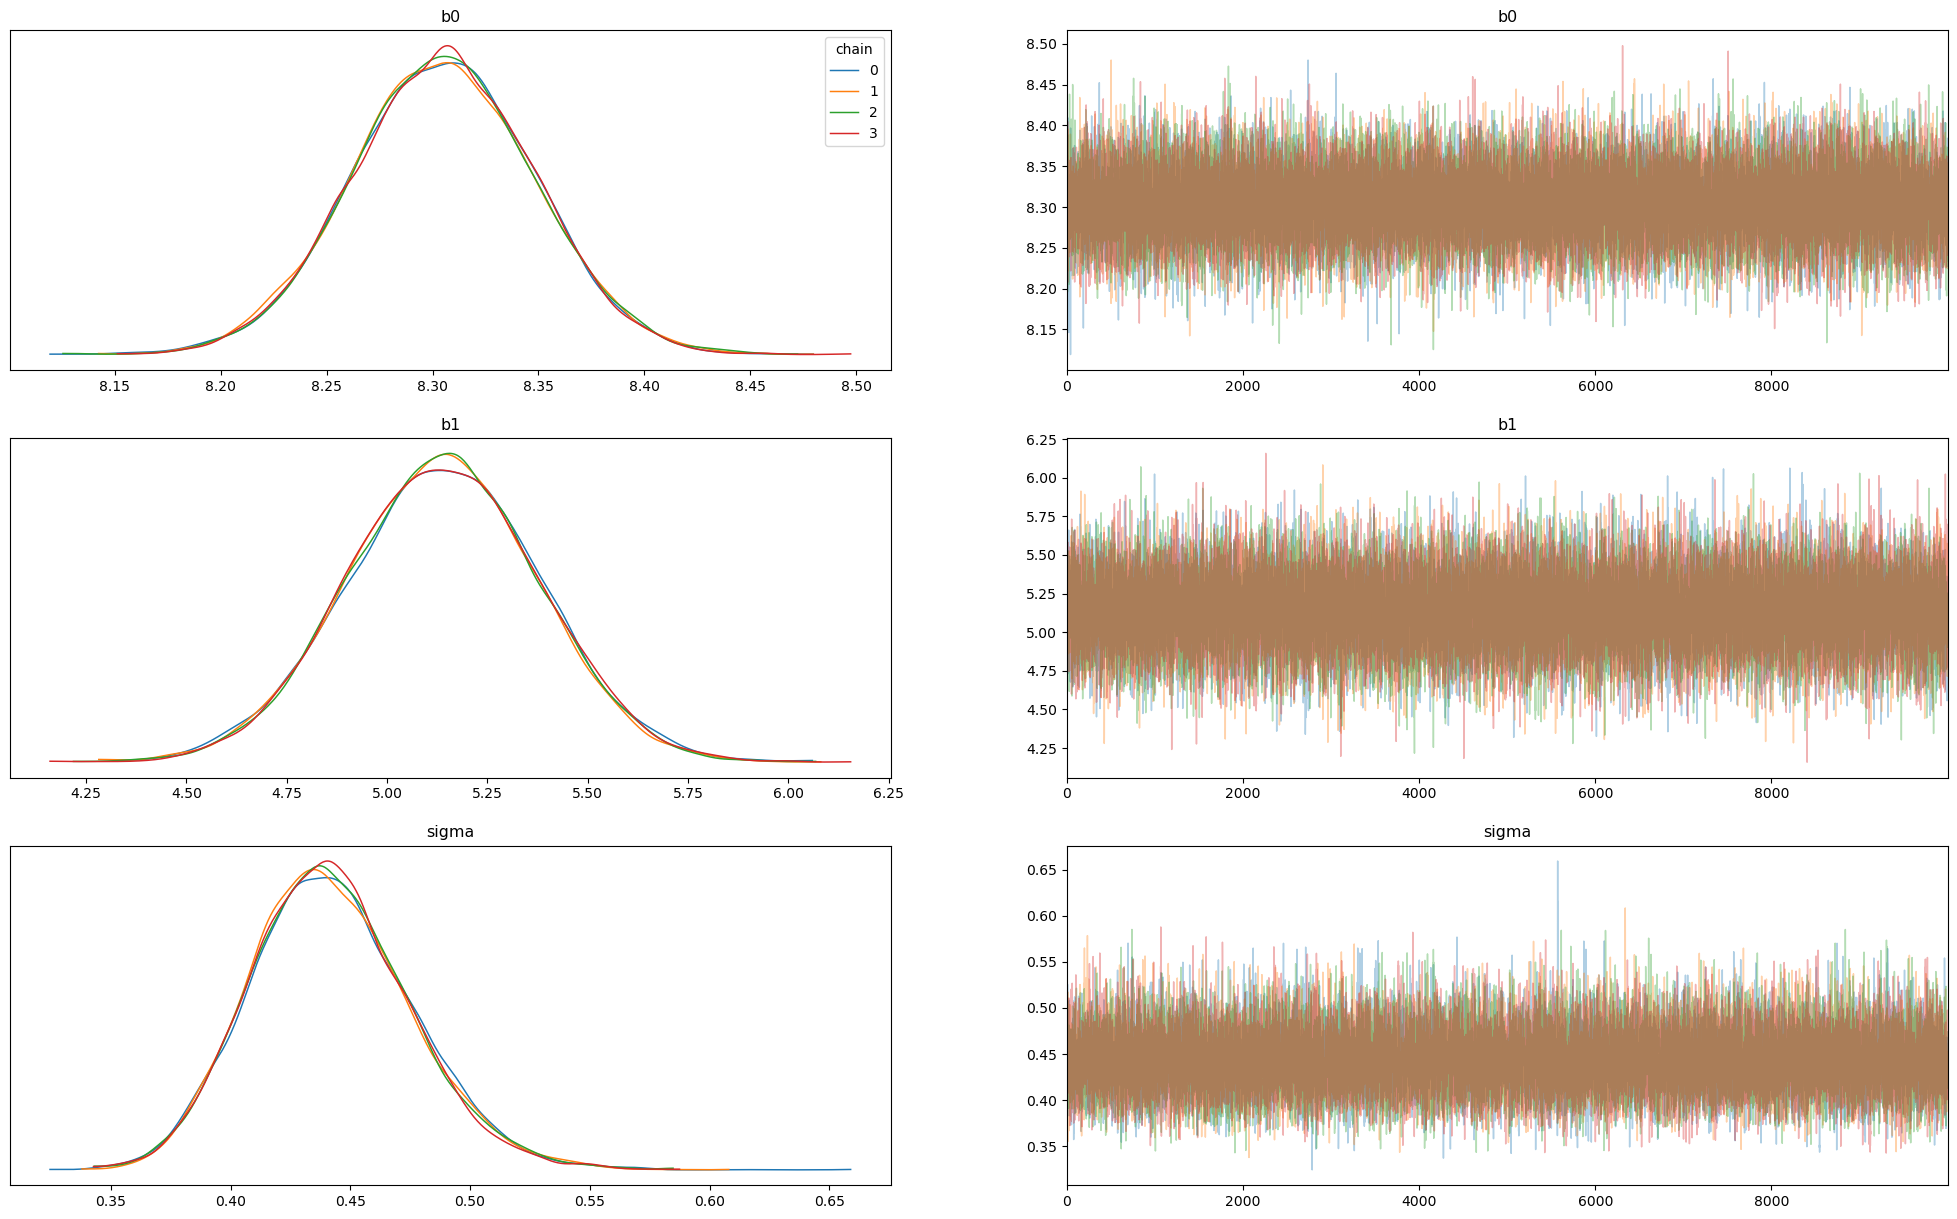

In [45]:
# Summary table of the trace
print('RESULTS FOR LINEAR MODEL WITH MEASUREMENT ERROR')
print('Prior mu and sigma for normal distribution for b0 and b1:', mu_prior, ',', sigma_prior)
print('Prior sigma for halfnormal for sigma:', sigma1_prior)
print()
trace_err_summary = az.summary((trace_err.posterior), kind="stats", var_names=["b0", "b1", "sigma"])
print(trace_err_summary)

# Trace plots
subsampled_err_trace = trace_err.sel(draw=slice(0, None, 1))
az.plot_trace(subsampled_err_trace, var_names=["b0", "b1", "sigma"], figsize=(25,15), compact=False, legend=True);# Summary table of the trace

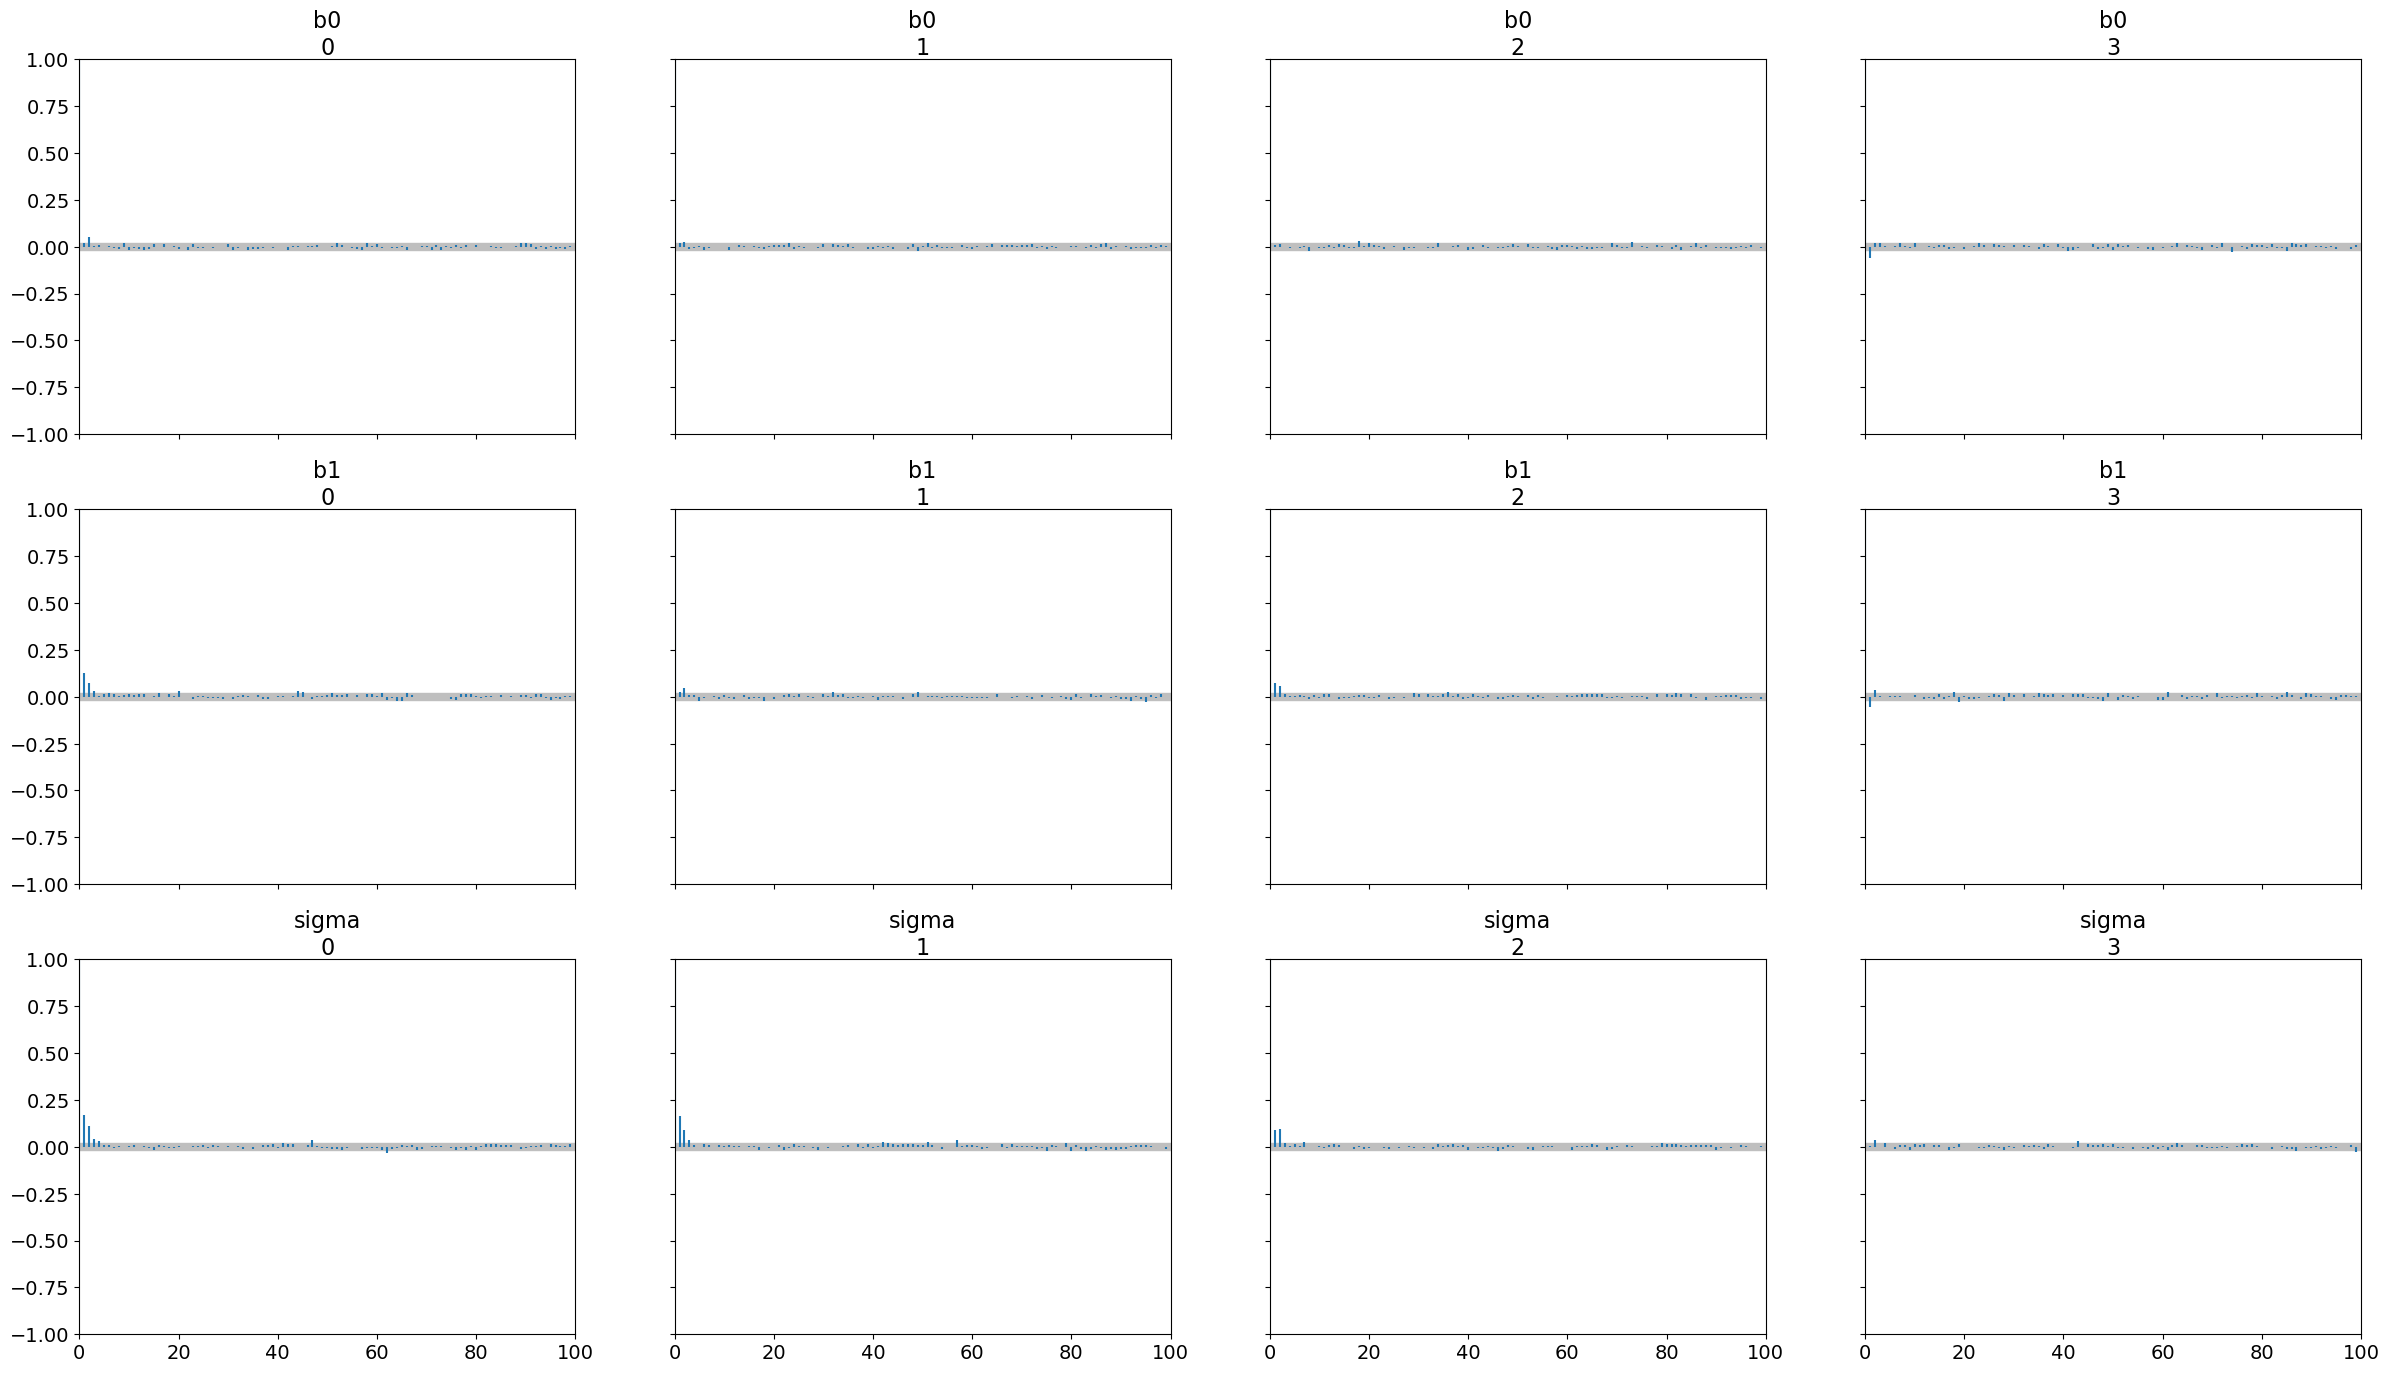

In [46]:
az.plot_autocorr(trace_err, var_names=['b0', 'b1', 'sigma'], figsize=None, grid=(3, 4) );

In [47]:
# Effective Sample Size
az.ess(trace_err, relative=False, var_names=["b0", "b1", "sigma"])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b0       float64 3.799e+04
    b1       float64 3.221e+04
    sigma    float64 2.603e+04

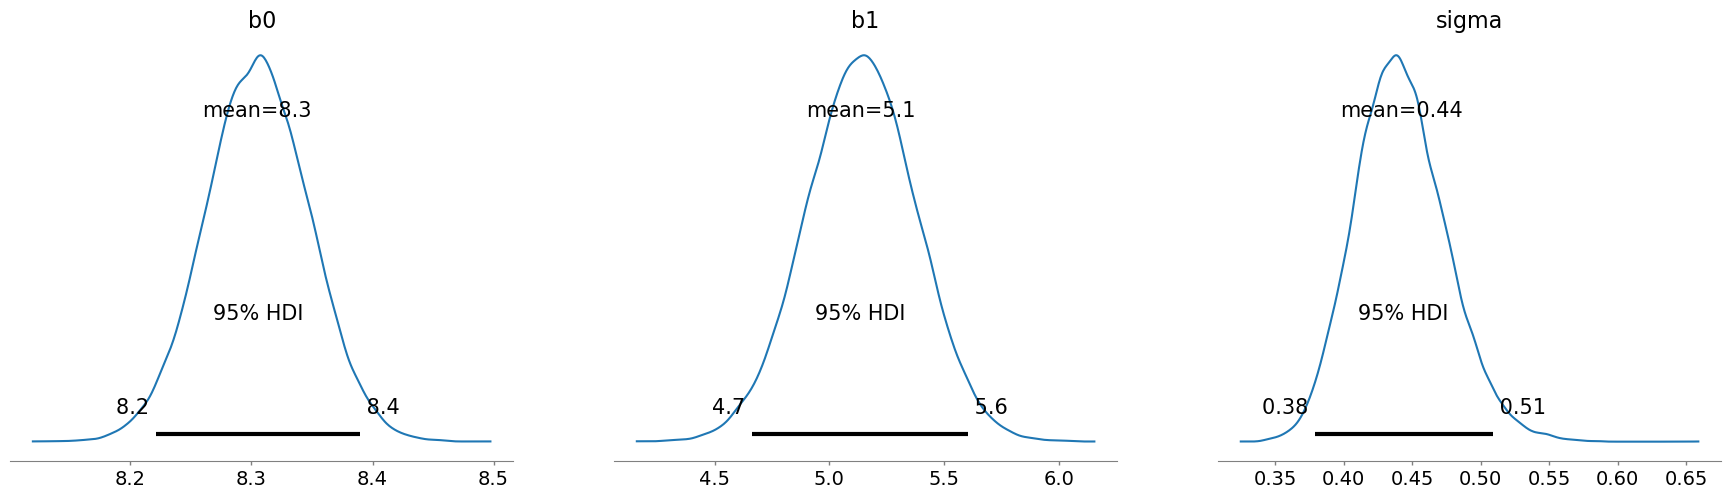

In [48]:
# Plot posterior histograms for beta0, beta1, and beta2
az.plot_posterior(trace_err, var_names=["b0", "b1", "sigma"],  hdi_prob=0.95);

## Posterior Predictive with Measurement Errors

Sampling: [Y_obs]
INFO:pymc.sampling.forward:Sampling: [Y_obs]


Output()

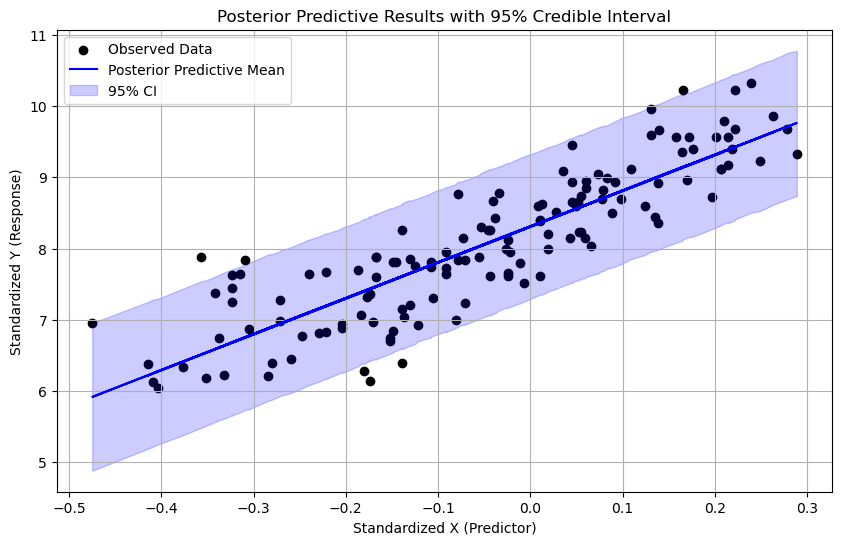

In [49]:
with model_err:
    posterior_predictive_err = pm.sample_posterior_predictive(trace_err, random_seed=RANDOM_SEED)

trace.extend(posterior_predictive) # Add poster_predictive to trace.

# Extract posterior predictive samples
y_pred_err = posterior_predictive_err.posterior_predictive["Y_obs"].values

# Flatten
y_pred_err = y_pred.reshape(-1, y_pred_err.shape[-1])  # Combine chains and draws

y_mean_err = np.mean(y_pred_err, axis=0)
y_lower_err = np.percentile(y_pred_err, 2.5, axis=0)
y_upper_err = np.percentile(y_pred_err, 97.5, axis=0)

array = np.array([data["X"], y_mean_err, y_lower_err, y_upper_err]).T 
plot_data = pd.DataFrame(data = array, columns = ['X', 'mean', 'lower', 'upper'])
plot_data = plot_data.sort_values(by='X')

plt.figure(figsize=(10, 6))
plt.scatter(data["X"], data["Y"], color="black", label="Observed Data")
plt.plot(data["X"], y_mean_err, color="blue", label="Posterior Predictive Mean")
plt.fill_between(plot_data["X"], plot_data['lower'], plot_data['upper'], color="blue", alpha=0.2, label="95% CI")
plt.xlabel("Standardized X (Predictor)")
plt.ylabel("Standardized Y (Response)")
plt.title("Posterior Predictive Results with 95% Credible Interval")
plt.legend()
plt.grid()
plt.show()